# Stochastic modelling of COVID19 dataset
## Initial setup

In [5]:
library(tidyr)
library(deSolve)
options(repr.plot.width = 8, repr.plot.height =2.5)

## Base Model: SIR
Now to warm up, we want to use the standard SIR model with no population dynamics:

$\frac{dS}{dt} = -\frac{\beta{S}{I}}{N}$

$\frac{dI}{dt} = \frac{\beta{S}{I}}{N} - \gamma{I}$

$\frac{dS}{dt} = \gamma{I}$

Creating this model in R:

In [6]:
SIR <- function(t, state, pars) {
  with(as.list(c(state, pars)), {
    N <- S + I + R
    dS_dt <- -b * I/N * S
    dI_dt <-  b * I/N * S - g * I
    dR_dt <-  g * I
    return(list(c(dS_dt, dI_dt, dR_dt)))
  })
}

We then create a function to return an approximate value for our model given all parameters:

In [7]:
prediction <- function (params, times) {
    xstart <- params[c("S.0","I.0", "R.0")]
    out <- ode(func=sir.model.closed, y=xstart,
               times=c(0,times),parms=params)
    out[-1,3]
}

## Dataset: Flu in Boarding School
We have the classic dataset from a flu outbreak in a boarding school

In [15]:
df <- data.frame(read.csv('BoardingSchoolFlu.csv'))
df

days,cases
1,3
2,8
3,28
4,75
5,221
6,291
7,255
8,235
9,190
10,126


And the graphing our cases over time:

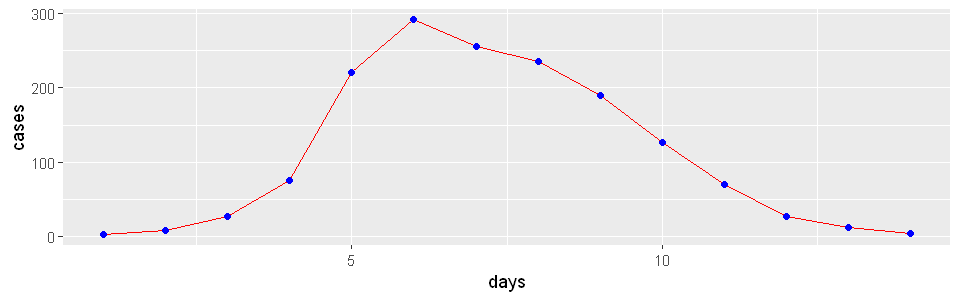

In [17]:
ggplot(data=df, aes(x=days, y=cases))+
  geom_line(linetype = "solid", color='red')+
  geom_point(color='blue')

## Parameter Estimation: MLE's using Normal Distribution 
We now want to create a maximum likelihood estimator of our model, with the aim of numerically maximising this to find estimates for our model's parameters. Initially, we assume our observerd errors are normally distributed.
Let $Y_t$ and $I_t$ denote the observed infections and infections according to our model at time $t$, respectively.
Using the normal distribution PDF:

$f(x|\mu, \sigma^2) = \frac{1}{\sqrt{2\pi}\sigma}\exp{\frac{-(x-\mu)^2}{2\sigma^2}}$.

Then our likelihood function is, for a sample size of $n$: 

$L = \displaystyle \prod_{t=0}^{n-1} f(Y_t|\mu=I_t, \sigma^2) = \prod_{t=0}^{n-1} \frac{1}{\sqrt{2\pi}\sigma}\exp{\frac{-(Y_t-I_t)^2}{2\sigma^2}} = \frac{1}{(2\pi)^\frac{n}{2}\sigma^n}\exp{-\sum_{t=0}^{n-1}\frac{-(Y_t-I_t)^2}{2\sigma^2}}$.

Then the log likelihood: 

$\log{L} = -\frac{n}{2}\log{((2\pi)}-n\log{\sigma}-\sum_{t=0}^{n-1}\frac{(Y_t - I_t)^2}{2\sigma^2}$